In [1]:
import sys

PWD = '../..'
sys.path.append(PWD)

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import norm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from src.plot_utils import plot_sample, plot_history
from src.cfd import CFD
from src.cfd_utils import TIME_STEP, plot_diff_hist_stats, _get_gauss_stats

In [2]:
dataset = np.load(PWD + f'/data/dataset_saturated.npz', allow_pickle=True)

In [3]:
all_channels_data = dataset['dataset'].flat[0]
all_channels_data.keys()

dict_keys([8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [4]:
all_X, all_y = all_channels_data[17][0], all_channels_data[17][1]

all_X.shape, all_y.shape

((4609, 64), (4609,))

# Preprocess

In [5]:
def augmentation_random_cut(X, y, n_edge_cut=8, seed=None, apply=True):
    if not apply:
        return X, y
    random_state = np.random.RandomState(seed)
    n_to_cut = n_edge_cut * 2
    
    start = random_state.randint(low=0, high=n_to_cut, size=X.shape[0])
    end = X.shape[1] - n_to_cut + start
    
    X_new = np.empty(shape=(X.shape[0], X.shape[1] - n_to_cut))
    for i in range(X.shape[0]):
        X_new[i] = X[i, start[i]:end[i]]
        
    y_new = y - start
    return X_new, y_new

In [6]:
n_baseline = 20

In [7]:
all_X -= np.mean(all_X[:, :n_baseline], axis=1)[:, None]

all_X /= all_X.max(axis=1)[:, None]

In [8]:
X_aug, y_aug = augmentation_random_cut(all_X, all_y, 8, seed=1344, apply=True)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = all_X, all_X, all_y, all_y # to see the same plots as in prepare_dataset

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3687, 48), (922, 48), (3687,), (922,))

# Utils

In [10]:
def plot_samples(X, y_true, y_pred, indices=[10, 11, 12, 13, 500, 800, 880, 900], Y_heatmap=None):
    plt.rc('font', size=9)
    for i, idx in enumerate(indices):
        plt.subplot(2, 4, i + 1)
            
        plot_sample(X[idx])
        plt.grid()
        plt.axvline(y_true[idx], c='red')
        plt.axvline(y_pred[idx], c='orange')
        
        if Y_heatmap is not None:
            _, _, mu, std, a = _get_gauss_stats(np.maximum(Y_heatmap[idx], 0), return_all=True)
            gauss_y = norm.pdf(np.arange(0, X.shape[1], 0.1), mu, std)
            gauss_y *= a / np.max(gauss_y)
            # for x, y in zip(np.arange(0, X.shape[1], 0.1), gauss_y):
            #     plt.axvspan(x - 0.05, x + 0.05, alpha=y * 0.7, color='limegreen')
            plt.plot(np.arange(0, X.shape[1], 0.1), gauss_y, c='limegreen', linewidth=1.5, linestyle='--')
        
        diff = abs(y_true[idx] - y_pred[idx])
        plt.title(f'Diff: {diff:0.4f} ({diff * TIME_STEP:0.4f}) ns')
    plt.tight_layout()
        
def plot_difference_hist(y_true, y_pred, channel, hist_range=(-2, 2), n_bins=100, xlabel=None):
    plt.rc('font', size=13)
    mu, std = plot_diff_hist_stats(y_true, y_pred, show=False, n_bins=n_bins, hist_range=hist_range, hist_label=f'', plot_gauss=True, return_gauss_stats=True)

    plt.title(f'Diff histogram (channel={channel}), mean={mu:0.3f}, std={std:0.3f}')
    if xlabel is not None:
        plt.xlabel(xlabel)
    plt.show()
    return std
    
def train_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, lr=0.001, name='model', train=True, n_epochs=1000, verbose=1, batch_size=256, lr_patience=None, es_patience=None, loss_weights=None):
    model.compile(loss='mse', optimizer=optimizers.Adam(lr), loss_weights=loss_weights)

    model_callbacks = []
    model_callbacks.append(callbacks.ModelCheckpoint(filepath=f'model_weights/nn_smearing_experiments_saturated/{name}/weights', save_best_only=True, save_weights_only=True))
    if es_patience is not None:
        model_callbacks.append(callbacks.EarlyStopping(patience=es_patience))
    if lr_patience is not None:
        model_callbacks.append(callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=lr_patience))
    
    if train:
        history = model.fit(X_train, y_train, epochs=n_epochs, verbose=verbose, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=model_callbacks).history
        pd.DataFrame(history).to_csv(f'model_weights/nn_smearing_experiments_saturated/{name}/loss_log.csv')

    model.load_weights(f'model_weights/nn_smearing_experiments_saturated/{name}/weights')
    history = pd.read_csv(f'model_weights/nn_smearing_experiments_saturated/{name}/loss_log.csv')
    
    return history

# CFD

In [11]:
cfd = CFD(n_baseline=10, fraction=0.23)

y_pred = []
for x in X_test:
    y_pred.append(cfd.predict(x))
    
y_pred = np.array(y_pred)
y_pred.shape

(922,)

In [12]:
mean_squared_error(y_test, y_pred)

0.36911705626448293

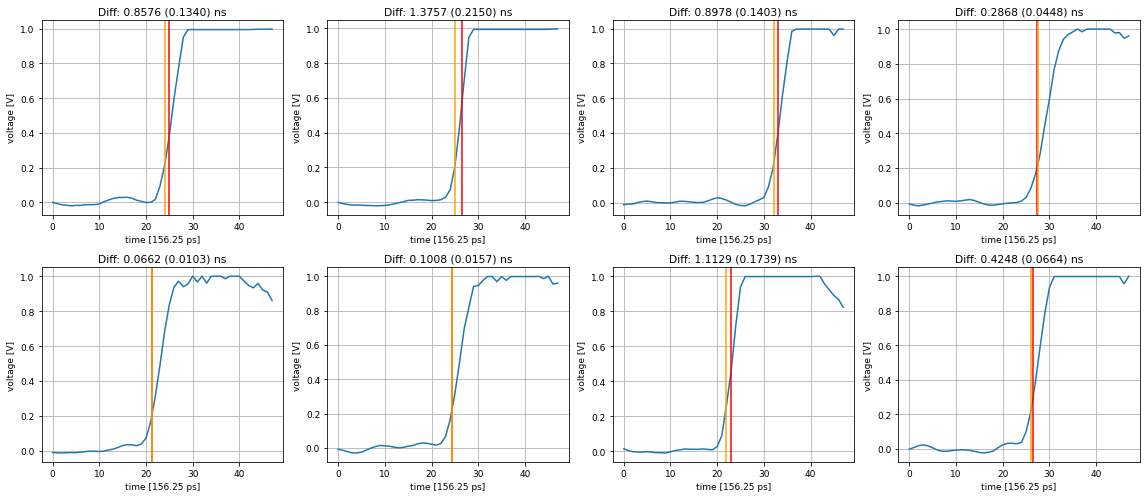

In [13]:
plt.figure(figsize=(16, 7))
plot_samples(X_test, y_test, y_pred)

In [14]:
y_pred.shape

(922,)

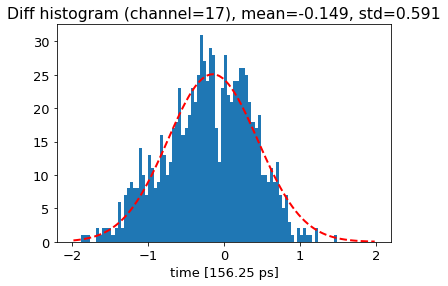

In [15]:
std_cfd = plot_difference_hist(y_test, y_pred, 17, hist_range=(-2, 2))

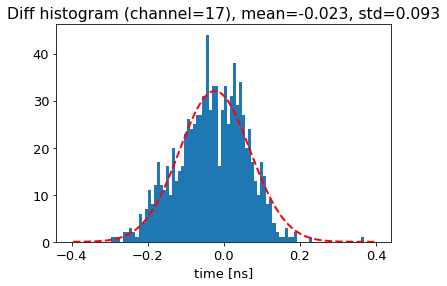

0.0926845385526594

In [16]:
plot_difference_hist(y_test * TIME_STEP, y_pred * TIME_STEP, 17, hist_range=(-0.4, 0.4), xlabel='time [ns]')

# Model 1

In [98]:
model = keras.Sequential([
    layers.Input(48),
    layers.Dense(1)
])

history = train_model(model, lr=0.1, name='model_1', train=True, n_epochs=3000, lr_patience=50, es_patience=400)

Epoch 1/3000
15/15 [==============================] - 0s 11ms/step - loss: 260.8008 - val_loss: 87.1926 - lr: 0.1000
Epoch 2/3000
15/15 [==============================] - 0s 5ms/step - loss: 78.9964 - val_loss: 41.2013 - lr: 0.1000
Epoch 3/3000
15/15 [==============================] - 0s 4ms/step - loss: 28.8322 - val_loss: 20.4183 - lr: 0.1000
Epoch 4/3000
15/15 [==============================] - 0s 4ms/step - loss: 14.6899 - val_loss: 10.3782 - lr: 0.1000
Epoch 5/3000
15/15 [==============================] - 0s 5ms/step - loss: 9.8060 - val_loss: 7.7020 - lr: 0.1000
Epoch 6/3000
15/15 [==============================] - 0s 5ms/step - loss: 7.9026 - val_loss: 6.1875 - lr: 0.1000
Epoch 7/3000
15/15 [==============================] - 0s 5ms/step - loss: 6.6507 - val_loss: 5.0950 - lr: 0.1000
Epoch 8/3000
15/15 [==============================] - 0s 5ms/step - loss: 5.7150 - val_loss: 4.2856 - lr: 0.1000
Epoch 9/3000
15/15 [==============================] - 0s 5ms/step - loss: 5.0682 - val

Epoch 73/3000
15/15 [==============================] - 0s 4ms/step - loss: 2.5700 - val_loss: 1.3014 - lr: 0.1000
Epoch 74/3000
15/15 [==============================] - 0s 4ms/step - loss: 2.5586 - val_loss: 1.2975 - lr: 0.1000
Epoch 75/3000
15/15 [==============================] - 0s 4ms/step - loss: 2.5595 - val_loss: 1.2725 - lr: 0.1000
Epoch 76/3000
15/15 [==============================] - 0s 5ms/step - loss: 2.5436 - val_loss: 1.2669 - lr: 0.1000
Epoch 77/3000
15/15 [==============================] - 0s 4ms/step - loss: 2.5355 - val_loss: 1.2510 - lr: 0.1000
Epoch 78/3000
15/15 [==============================] - 0s 4ms/step - loss: 2.5275 - val_loss: 1.2487 - lr: 0.1000
Epoch 79/3000
15/15 [==============================] - 0s 4ms/step - loss: 2.5220 - val_loss: 1.2356 - lr: 0.1000
Epoch 80/3000
15/15 [==============================] - 0s 5ms/step - loss: 2.5122 - val_loss: 1.2264 - lr: 0.1000
Epoch 81/3000
15/15 [==============================] - 0s 3ms/step - loss: 2.5177 - val_

15/15 [==============================] - 0s 3ms/step - loss: 2.2017 - val_loss: 0.9108 - lr: 0.1000
Epoch 145/3000
15/15 [==============================] - 0s 5ms/step - loss: 2.2095 - val_loss: 0.8725 - lr: 0.1000
Epoch 146/3000
15/15 [==============================] - 0s 3ms/step - loss: 2.2022 - val_loss: 0.9113 - lr: 0.1000
Epoch 147/3000
15/15 [==============================] - 0s 4ms/step - loss: 2.2032 - val_loss: 0.8626 - lr: 0.1000
Epoch 148/3000
15/15 [==============================] - 0s 3ms/step - loss: 2.1939 - val_loss: 0.8713 - lr: 0.1000
Epoch 149/3000
15/15 [==============================] - 0s 3ms/step - loss: 2.1926 - val_loss: 0.8883 - lr: 0.1000
Epoch 150/3000
15/15 [==============================] - 0s 5ms/step - loss: 2.1989 - val_loss: 0.8554 - lr: 0.1000
Epoch 151/3000
15/15 [==============================] - 0s 4ms/step - loss: 2.1897 - val_loss: 0.8527 - lr: 0.1000
Epoch 152/3000
15/15 [==============================] - 0s 3ms/step - loss: 2.1853 - val_loss: 

15/15 [==============================] - 0s 3ms/step - loss: 2.0503 - val_loss: 0.7023 - lr: 0.1000
Epoch 216/3000
15/15 [==============================] - 0s 3ms/step - loss: 2.0580 - val_loss: 0.7568 - lr: 0.1000
Epoch 217/3000
15/15 [==============================] - 0s 3ms/step - loss: 2.0981 - val_loss: 0.7469 - lr: 0.1000
Epoch 218/3000
15/15 [==============================] - 0s 3ms/step - loss: 2.0741 - val_loss: 0.7057 - lr: 0.1000
Epoch 219/3000
15/15 [==============================] - 0s 3ms/step - loss: 2.0553 - val_loss: 0.7551 - lr: 0.1000
Epoch 220/3000
15/15 [==============================] - 0s 5ms/step - loss: 2.0538 - val_loss: 0.6962 - lr: 0.1000
Epoch 221/3000
15/15 [==============================] - 0s 3ms/step - loss: 2.0460 - val_loss: 0.7397 - lr: 0.1000
Epoch 222/3000
15/15 [==============================] - 0s 3ms/step - loss: 2.0518 - val_loss: 0.6978 - lr: 0.1000
Epoch 223/3000
15/15 [==============================] - 0s 3ms/step - loss: 2.0361 - val_loss: 

15/15 [==============================] - 0s 3ms/step - loss: 1.9543 - val_loss: 0.6923 - lr: 0.1000
Epoch 287/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.9678 - val_loss: 0.7377 - lr: 0.1000
Epoch 288/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.9832 - val_loss: 0.6475 - lr: 0.1000
Epoch 289/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.9568 - val_loss: 0.7600 - lr: 0.1000
Epoch 290/3000
15/15 [==============================] - 0s 3ms/step - loss: 2.0181 - val_loss: 1.0803 - lr: 0.1000
Epoch 291/3000
15/15 [==============================] - 0s 3ms/step - loss: 2.0827 - val_loss: 0.5903 - lr: 0.1000
Epoch 292/3000
15/15 [==============================] - 0s 3ms/step - loss: 2.0225 - val_loss: 0.6008 - lr: 0.1000
Epoch 293/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.9676 - val_loss: 0.6023 - lr: 0.1000
Epoch 294/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.9490 - val_loss: 

15/15 [==============================] - 0s 5ms/step - loss: 1.8567 - val_loss: 0.5077 - lr: 0.1000
Epoch 358/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8652 - val_loss: 0.5091 - lr: 0.1000
Epoch 359/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8648 - val_loss: 0.5703 - lr: 0.1000
Epoch 360/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8616 - val_loss: 0.5088 - lr: 0.1000
Epoch 361/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8733 - val_loss: 0.5673 - lr: 0.1000
Epoch 362/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.8970 - val_loss: 0.4971 - lr: 0.1000
Epoch 363/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8489 - val_loss: 0.5030 - lr: 0.1000
Epoch 364/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8675 - val_loss: 0.5380 - lr: 0.1000
Epoch 365/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.8731 - val_loss: 

15/15 [==============================] - 0s 3ms/step - loss: 1.8418 - val_loss: 0.4729 - lr: 0.1000
Epoch 429/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8469 - val_loss: 0.4661 - lr: 0.1000
Epoch 430/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8373 - val_loss: 0.4840 - lr: 0.1000
Epoch 431/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.8437 - val_loss: 0.4570 - lr: 0.1000
Epoch 432/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8254 - val_loss: 0.4795 - lr: 0.1000
Epoch 433/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8343 - val_loss: 0.4826 - lr: 0.1000
Epoch 434/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8377 - val_loss: 0.4844 - lr: 0.1000
Epoch 435/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8514 - val_loss: 0.7383 - lr: 0.1000
Epoch 436/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.9216 - val_loss: 

15/15 [==============================] - 0s 3ms/step - loss: 1.8080 - val_loss: 0.4909 - lr: 0.1000
Epoch 500/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7987 - val_loss: 0.4486 - lr: 0.1000
Epoch 501/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8052 - val_loss: 0.4543 - lr: 0.1000
Epoch 502/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8627 - val_loss: 0.6400 - lr: 0.1000
Epoch 503/3000
15/15 [==============================] - 0s 5ms/step - loss: 1.8651 - val_loss: 0.4447 - lr: 0.1000
Epoch 504/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8809 - val_loss: 0.5066 - lr: 0.1000
Epoch 505/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8208 - val_loss: 0.4460 - lr: 0.1000
Epoch 506/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8204 - val_loss: 0.4706 - lr: 0.1000
Epoch 507/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8439 - val_loss: 

15/15 [==============================] - 0s 3ms/step - loss: 1.8252 - val_loss: 0.4556 - lr: 0.1000
Epoch 571/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8057 - val_loss: 0.4501 - lr: 0.1000
Epoch 572/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8112 - val_loss: 0.4687 - lr: 0.1000
Epoch 573/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8360 - val_loss: 0.5351 - lr: 0.1000
Epoch 574/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8563 - val_loss: 0.4730 - lr: 0.1000
Epoch 575/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8423 - val_loss: 0.4552 - lr: 0.1000
Epoch 576/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8098 - val_loss: 0.4525 - lr: 0.1000
Epoch 577/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8028 - val_loss: 0.5049 - lr: 0.1000
Epoch 578/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8285 - val_loss: 

15/15 [==============================] - 0s 3ms/step - loss: 1.8549 - val_loss: 0.4369 - lr: 0.0500
Epoch 642/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7916 - val_loss: 0.4976 - lr: 0.0500
Epoch 643/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7883 - val_loss: 0.4313 - lr: 0.0500
Epoch 644/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7900 - val_loss: 0.4533 - lr: 0.0500
Epoch 645/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8131 - val_loss: 0.4373 - lr: 0.0500
Epoch 646/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8199 - val_loss: 0.4424 - lr: 0.0500
Epoch 647/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7878 - val_loss: 0.4588 - lr: 0.0500
Epoch 648/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7843 - val_loss: 0.4414 - lr: 0.0500
Epoch 649/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7870 - val_loss: 

15/15 [==============================] - 0s 3ms/step - loss: 1.7883 - val_loss: 0.4456 - lr: 0.0250
Epoch 713/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7860 - val_loss: 0.4330 - lr: 0.0250
Epoch 714/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7846 - val_loss: 0.4410 - lr: 0.0250
Epoch 715/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7807 - val_loss: 0.4356 - lr: 0.0250
Epoch 716/3000
15/15 [==============================] - 0s 5ms/step - loss: 1.7820 - val_loss: 0.4305 - lr: 0.0250
Epoch 717/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7858 - val_loss: 0.4421 - lr: 0.0250
Epoch 718/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7951 - val_loss: 0.4543 - lr: 0.0250
Epoch 719/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7870 - val_loss: 0.4401 - lr: 0.0250
Epoch 720/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7843 - val_loss: 

15/15 [==============================] - 0s 3ms/step - loss: 1.7794 - val_loss: 0.4313 - lr: 0.0125
Epoch 784/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7827 - val_loss: 0.4383 - lr: 0.0125
Epoch 785/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7790 - val_loss: 0.4328 - lr: 0.0125
Epoch 786/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7790 - val_loss: 0.4523 - lr: 0.0125
Epoch 787/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7793 - val_loss: 0.4333 - lr: 0.0125
Epoch 788/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7808 - val_loss: 0.4324 - lr: 0.0125
Epoch 789/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7804 - val_loss: 0.4310 - lr: 0.0125
Epoch 790/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7769 - val_loss: 0.4342 - lr: 0.0125
Epoch 791/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7788 - val_loss: 

15/15 [==============================] - 0s 3ms/step - loss: 1.7781 - val_loss: 0.4359 - lr: 0.0063
Epoch 855/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7754 - val_loss: 0.4359 - lr: 0.0063
Epoch 856/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7770 - val_loss: 0.4328 - lr: 0.0063
Epoch 857/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7799 - val_loss: 0.4338 - lr: 0.0063
Epoch 858/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7753 - val_loss: 0.4344 - lr: 0.0063
Epoch 859/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7759 - val_loss: 0.4314 - lr: 0.0063
Epoch 860/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7782 - val_loss: 0.4302 - lr: 0.0063
Epoch 861/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7902 - val_loss: 0.4522 - lr: 0.0063
Epoch 862/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7859 - val_loss: 

15/15 [==============================] - 0s 3ms/step - loss: 1.7760 - val_loss: 0.4343 - lr: 0.0031
Epoch 926/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7777 - val_loss: 0.4340 - lr: 0.0031
Epoch 927/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.7741 - val_loss: 0.4312 - lr: 0.0031
Epoch 928/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.7755 - val_loss: 0.4360 - lr: 0.0031
Epoch 929/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7751 - val_loss: 0.4318 - lr: 0.0031
Epoch 930/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7744 - val_loss: 0.4345 - lr: 0.0031
Epoch 931/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7783 - val_loss: 0.4310 - lr: 0.0031
Epoch 932/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7767 - val_loss: 0.4332 - lr: 0.0031
Epoch 933/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7809 - val_loss: 

15/15 [==============================] - 0s 3ms/step - loss: 1.7758 - val_loss: 0.4358 - lr: 0.0031
Epoch 997/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7765 - val_loss: 0.4318 - lr: 0.0031
Epoch 998/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7748 - val_loss: 0.4331 - lr: 0.0031
Epoch 999/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7758 - val_loss: 0.4325 - lr: 0.0031
Epoch 1000/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7751 - val_loss: 0.4305 - lr: 0.0031
Epoch 1001/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7752 - val_loss: 0.4347 - lr: 0.0031
Epoch 1002/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7759 - val_loss: 0.4314 - lr: 0.0031
Epoch 1003/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7747 - val_loss: 0.4319 - lr: 0.0031
Epoch 1004/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7751 - val_l

15/15 [==============================] - 0s 3ms/step - loss: 1.7744 - val_loss: 0.4322 - lr: 7.8125e-04
Epoch 1067/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7739 - val_loss: 0.4314 - lr: 7.8125e-04
Epoch 1068/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7741 - val_loss: 0.4316 - lr: 7.8125e-04
Epoch 1069/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7745 - val_loss: 0.4314 - lr: 7.8125e-04
Epoch 1070/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7747 - val_loss: 0.4308 - lr: 7.8125e-04
Epoch 1071/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7753 - val_loss: 0.4325 - lr: 7.8125e-04
Epoch 1072/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7743 - val_loss: 0.4315 - lr: 7.8125e-04
Epoch 1073/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7739 - val_loss: 0.4313 - lr: 7.8125e-04
Epoch 1074/3000
15/15 [==============================] -

15/15 [==============================] - 0s 3ms/step - loss: 1.7741 - val_loss: 0.4335 - lr: 3.9063e-04
Epoch 1135/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7742 - val_loss: 0.4324 - lr: 3.9063e-04
Epoch 1136/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7739 - val_loss: 0.4326 - lr: 3.9063e-04
Epoch 1137/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7739 - val_loss: 0.4325 - lr: 3.9063e-04
Epoch 1138/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7739 - val_loss: 0.4326 - lr: 3.9063e-04
Epoch 1139/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7739 - val_loss: 0.4317 - lr: 3.9063e-04
Epoch 1140/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7739 - val_loss: 0.4320 - lr: 3.9063e-04
Epoch 1141/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7738 - val_loss: 0.4322 - lr: 3.9063e-04
Epoch 1142/3000
15/15 [==============================] -

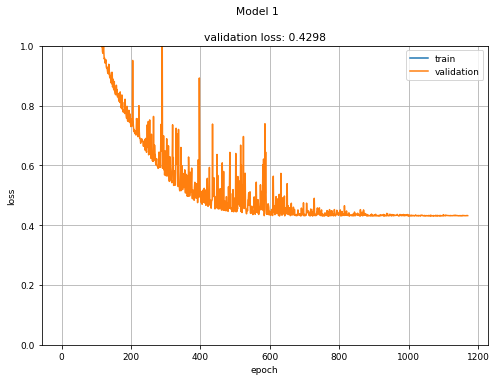

In [99]:
plot_history(history, "Model 1", ymax=1.)

29/29 [==============================] - 0s 714us/step


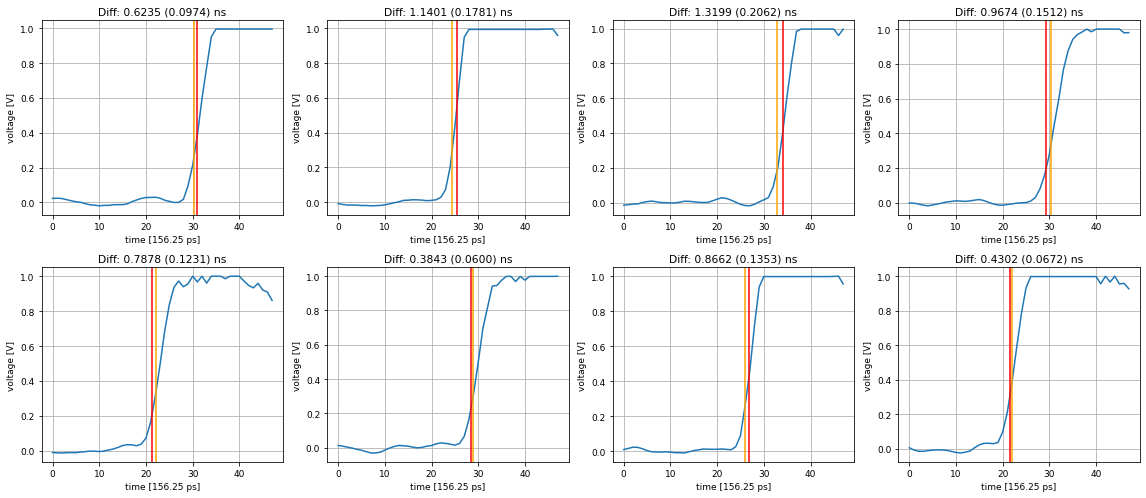

In [100]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

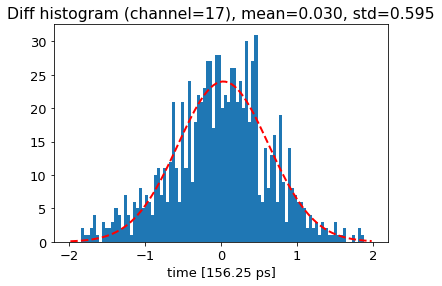

In [101]:
std_1 = plot_difference_hist(y_test, y_pred, 17)

# Model 2

In [17]:
model = keras.Sequential([
    layers.Input(48),
    
    layers.Dense(48, activation='relu'),
    layers.Dense(24, activation='relu'),
    layers.Dense(12, activation='relu'),
    layers.Dense(1)
])

history = train_model(model, lr=0.01, name='model_2', train=True, n_epochs=3000, lr_patience=50, es_patience=400)

Epoch 1/3000
15/15 [==============================] - 1s 18ms/step - loss: 308.5940 - val_loss: 85.0716 - lr: 0.0100
Epoch 2/3000
15/15 [==============================] - 0s 6ms/step - loss: 56.9042 - val_loss: 23.4839 - lr: 0.0100
Epoch 3/3000
15/15 [==============================] - 0s 6ms/step - loss: 16.8491 - val_loss: 4.7415 - lr: 0.0100
Epoch 4/3000
15/15 [==============================] - 0s 6ms/step - loss: 6.7024 - val_loss: 4.0256 - lr: 0.0100
Epoch 5/3000
15/15 [==============================] - 0s 6ms/step - loss: 4.4649 - val_loss: 2.3097 - lr: 0.0100
Epoch 6/3000
15/15 [==============================] - 0s 5ms/step - loss: 3.4843 - val_loss: 1.7810 - lr: 0.0100
Epoch 7/3000
15/15 [==============================] - 0s 5ms/step - loss: 3.0778 - val_loss: 1.5715 - lr: 0.0100
Epoch 8/3000
15/15 [==============================] - 0s 6ms/step - loss: 2.8810 - val_loss: 1.4130 - lr: 0.0100
Epoch 9/3000
15/15 [==============================] - 0s 6ms/step - loss: 2.7388 - val_lo

Epoch 73/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.8439 - val_loss: 0.4653 - lr: 0.0100
Epoch 74/3000
15/15 [==============================] - 0s 5ms/step - loss: 1.8211 - val_loss: 0.4614 - lr: 0.0100
Epoch 75/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8574 - val_loss: 0.5373 - lr: 0.0100
Epoch 76/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.8613 - val_loss: 0.4794 - lr: 0.0100
Epoch 77/3000
15/15 [==============================] - 0s 5ms/step - loss: 1.8374 - val_loss: 0.4508 - lr: 0.0100
Epoch 78/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8085 - val_loss: 0.6438 - lr: 0.0100
Epoch 79/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8915 - val_loss: 0.4881 - lr: 0.0100
Epoch 80/3000
15/15 [==============================] - 0s 5ms/step - loss: 1.8128 - val_loss: 0.4418 - lr: 0.0100
Epoch 81/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.8501 - val_

15/15 [==============================] - 0s 3ms/step - loss: 1.9818 - val_loss: 0.5636 - lr: 0.0100
Epoch 145/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.9399 - val_loss: 0.7927 - lr: 0.0100
Epoch 146/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8184 - val_loss: 0.3688 - lr: 0.0100
Epoch 147/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7937 - val_loss: 0.4280 - lr: 0.0100
Epoch 148/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7528 - val_loss: 0.3840 - lr: 0.0100
Epoch 149/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.6976 - val_loss: 0.4069 - lr: 0.0100
Epoch 150/3000
15/15 [==============================] - 0s 5ms/step - loss: 1.7413 - val_loss: 0.3576 - lr: 0.0100
Epoch 151/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7607 - val_loss: 0.4047 - lr: 0.0100
Epoch 152/3000
15/15 [==============================] - 0s 5ms/step - loss: 1.7495 - val_loss: 

15/15 [==============================] - 0s 5ms/step - loss: 1.6745 - val_loss: 0.3089 - lr: 0.0100
Epoch 216/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7412 - val_loss: 0.3254 - lr: 0.0100
Epoch 217/3000
15/15 [==============================] - 0s 5ms/step - loss: 1.6520 - val_loss: 0.2926 - lr: 0.0100
Epoch 218/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7051 - val_loss: 0.4036 - lr: 0.0100
Epoch 219/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.6996 - val_loss: 0.3147 - lr: 0.0100
Epoch 220/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7307 - val_loss: 1.3090 - lr: 0.0100
Epoch 221/3000
15/15 [==============================] - 0s 3ms/step - loss: 2.1371 - val_loss: 0.8670 - lr: 0.0100
Epoch 222/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8538 - val_loss: 0.6027 - lr: 0.0100
Epoch 223/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7834 - val_loss: 

15/15 [==============================] - 0s 3ms/step - loss: 1.6239 - val_loss: 0.2794 - lr: 0.0100
Epoch 287/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.6796 - val_loss: 0.2927 - lr: 0.0100
Epoch 288/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.6679 - val_loss: 0.4823 - lr: 0.0100
Epoch 289/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.6891 - val_loss: 0.3666 - lr: 0.0100
Epoch 290/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7539 - val_loss: 0.3221 - lr: 0.0100
Epoch 291/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.6531 - val_loss: 0.3196 - lr: 0.0100
Epoch 292/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.6611 - val_loss: 0.6003 - lr: 0.0100
Epoch 293/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.8131 - val_loss: 0.2839 - lr: 0.0100
Epoch 294/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.6944 - val_loss: 

15/15 [==============================] - 0s 3ms/step - loss: 1.6098 - val_loss: 0.2756 - lr: 0.0100
Epoch 358/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.6721 - val_loss: 0.3475 - lr: 0.0100
Epoch 359/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.6423 - val_loss: 0.3523 - lr: 0.0100
Epoch 360/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7186 - val_loss: 0.3731 - lr: 0.0100
Epoch 361/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.6814 - val_loss: 0.2595 - lr: 0.0100
Epoch 362/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.7075 - val_loss: 0.4640 - lr: 0.0100
Epoch 363/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.6621 - val_loss: 0.3464 - lr: 0.0100
Epoch 364/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.6652 - val_loss: 0.2543 - lr: 0.0100
Epoch 365/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.6217 - val_loss: 

15/15 [==============================] - 0s 3ms/step - loss: 1.6652 - val_loss: 0.4501 - lr: 0.0050
Epoch 429/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.6752 - val_loss: 0.3293 - lr: 0.0050
Epoch 430/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.7209 - val_loss: 0.3311 - lr: 0.0050
Epoch 431/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.6045 - val_loss: 0.2507 - lr: 0.0050
Epoch 432/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5867 - val_loss: 0.2636 - lr: 0.0050
Epoch 433/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.6280 - val_loss: 0.2445 - lr: 0.0050
Epoch 434/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.6006 - val_loss: 0.2466 - lr: 0.0050
Epoch 435/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.6282 - val_loss: 0.2638 - lr: 0.0050
Epoch 436/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.6123 - val_loss: 

15/15 [==============================] - 0s 5ms/step - loss: 1.5576 - val_loss: 0.2322 - lr: 0.0025
Epoch 500/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5723 - val_loss: 0.2395 - lr: 0.0025
Epoch 501/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5631 - val_loss: 0.2643 - lr: 0.0025
Epoch 502/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5584 - val_loss: 0.2441 - lr: 0.0025
Epoch 503/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5562 - val_loss: 0.2376 - lr: 0.0025
Epoch 504/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5634 - val_loss: 0.2347 - lr: 0.0025
Epoch 505/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5646 - val_loss: 0.3599 - lr: 0.0025
Epoch 506/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.6407 - val_loss: 0.2644 - lr: 0.0025
Epoch 507/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5800 - val_loss: 

15/15 [==============================] - 0s 3ms/step - loss: 1.5860 - val_loss: 0.2776 - lr: 0.0025
Epoch 571/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5632 - val_loss: 0.2332 - lr: 0.0025
Epoch 572/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5493 - val_loss: 0.2393 - lr: 0.0025
Epoch 573/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5910 - val_loss: 0.2322 - lr: 0.0025
Epoch 574/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5625 - val_loss: 0.2909 - lr: 0.0025
Epoch 575/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5592 - val_loss: 0.2387 - lr: 0.0025
Epoch 576/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5541 - val_loss: 0.2460 - lr: 0.0025
Epoch 577/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5589 - val_loss: 0.2769 - lr: 0.0025
Epoch 578/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5527 - val_loss: 

15/15 [==============================] - 0s 3ms/step - loss: 1.5454 - val_loss: 0.2894 - lr: 0.0025
Epoch 642/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5765 - val_loss: 0.2599 - lr: 0.0025
Epoch 643/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5684 - val_loss: 0.2366 - lr: 0.0025
Epoch 644/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5569 - val_loss: 0.2254 - lr: 0.0025
Epoch 645/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.6112 - val_loss: 0.2494 - lr: 0.0025
Epoch 646/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5613 - val_loss: 0.2399 - lr: 0.0025
Epoch 647/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5429 - val_loss: 0.2269 - lr: 0.0012
Epoch 648/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5424 - val_loss: 0.2571 - lr: 0.0012
Epoch 649/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5435 - val_loss: 

15/15 [==============================] - 0s 3ms/step - loss: 1.5405 - val_loss: 0.2474 - lr: 0.0012
Epoch 713/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5578 - val_loss: 0.2342 - lr: 0.0012
Epoch 714/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5557 - val_loss: 0.2196 - lr: 0.0012
Epoch 715/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5411 - val_loss: 0.2185 - lr: 0.0012
Epoch 716/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5311 - val_loss: 0.2390 - lr: 0.0012
Epoch 717/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5334 - val_loss: 0.2180 - lr: 0.0012
Epoch 718/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5293 - val_loss: 0.2246 - lr: 0.0012
Epoch 719/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5570 - val_loss: 0.2239 - lr: 0.0012
Epoch 720/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5285 - val_loss: 

15/15 [==============================] - 0s 4ms/step - loss: 1.5244 - val_loss: 0.2212 - lr: 0.0012
Epoch 784/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5274 - val_loss: 0.2239 - lr: 0.0012
Epoch 785/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5287 - val_loss: 0.2149 - lr: 0.0012
Epoch 786/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5340 - val_loss: 0.2160 - lr: 0.0012
Epoch 787/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5325 - val_loss: 0.2219 - lr: 0.0012
Epoch 788/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5224 - val_loss: 0.2129 - lr: 0.0012
Epoch 789/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5300 - val_loss: 0.2353 - lr: 0.0012
Epoch 790/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5369 - val_loss: 0.2164 - lr: 0.0012
Epoch 791/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5292 - val_loss: 

15/15 [==============================] - 0s 4ms/step - loss: 1.5411 - val_loss: 0.2618 - lr: 0.0012
Epoch 855/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5391 - val_loss: 0.2138 - lr: 0.0012
Epoch 856/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5253 - val_loss: 0.2156 - lr: 0.0012
Epoch 857/3000
15/15 [==============================] - 0s 6ms/step - loss: 1.5400 - val_loss: 0.2087 - lr: 0.0012
Epoch 858/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5301 - val_loss: 0.2102 - lr: 0.0012
Epoch 859/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5344 - val_loss: 0.2175 - lr: 0.0012
Epoch 860/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5251 - val_loss: 0.2111 - lr: 0.0012
Epoch 861/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5279 - val_loss: 0.2200 - lr: 0.0012
Epoch 862/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5373 - val_loss: 

15/15 [==============================] - 0s 4ms/step - loss: 1.5342 - val_loss: 0.2423 - lr: 0.0012
Epoch 926/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5445 - val_loss: 0.2380 - lr: 0.0012
Epoch 927/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5538 - val_loss: 0.2256 - lr: 0.0012
Epoch 928/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5289 - val_loss: 0.2148 - lr: 0.0012
Epoch 929/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5280 - val_loss: 0.2093 - lr: 0.0012
Epoch 930/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5283 - val_loss: 0.2122 - lr: 0.0012
Epoch 931/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5150 - val_loss: 0.2070 - lr: 0.0012
Epoch 932/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5175 - val_loss: 0.2064 - lr: 0.0012
Epoch 933/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5214 - val_loss: 

Epoch 996/3000
15/15 [==============================] - 0s 5ms/step - loss: 1.5255 - val_loss: 0.2039 - lr: 6.2500e-04
Epoch 997/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5225 - val_loss: 0.2170 - lr: 6.2500e-04
Epoch 998/3000
15/15 [==============================] - 0s 5ms/step - loss: 1.5225 - val_loss: 0.2037 - lr: 6.2500e-04
Epoch 999/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5127 - val_loss: 0.2093 - lr: 6.2500e-04
Epoch 1000/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5151 - val_loss: 0.2116 - lr: 6.2500e-04
Epoch 1001/3000
15/15 [==============================] - 0s 5ms/step - loss: 1.5201 - val_loss: 0.2037 - lr: 6.2500e-04
Epoch 1002/3000
15/15 [==============================] - 0s 5ms/step - loss: 1.5137 - val_loss: 0.2028 - lr: 6.2500e-04
Epoch 1003/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5105 - val_loss: 0.2092 - lr: 6.2500e-04
Epoch 1004/3000
15/15 [=====================

15/15 [==============================] - 0s 4ms/step - loss: 1.5162 - val_loss: 0.2101 - lr: 6.2500e-04
Epoch 1065/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5162 - val_loss: 0.2100 - lr: 6.2500e-04
Epoch 1066/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5182 - val_loss: 0.2167 - lr: 6.2500e-04
Epoch 1067/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5338 - val_loss: 0.2056 - lr: 6.2500e-04
Epoch 1068/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5142 - val_loss: 0.2095 - lr: 6.2500e-04
Epoch 1069/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5118 - val_loss: 0.2403 - lr: 6.2500e-04
Epoch 1070/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5309 - val_loss: 0.2089 - lr: 6.2500e-04
Epoch 1071/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5086 - val_loss: 0.2097 - lr: 6.2500e-04
Epoch 1072/3000
15/15 [==============================] -

15/15 [==============================] - 0s 3ms/step - loss: 1.5169 - val_loss: 0.2047 - lr: 6.2500e-04
Epoch 1133/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5216 - val_loss: 0.2114 - lr: 6.2500e-04
Epoch 1134/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5076 - val_loss: 0.2020 - lr: 6.2500e-04
Epoch 1135/3000
15/15 [==============================] - 0s 5ms/step - loss: 1.5121 - val_loss: 0.2011 - lr: 6.2500e-04
Epoch 1136/3000
15/15 [==============================] - 0s 6ms/step - loss: 1.5168 - val_loss: 0.2005 - lr: 6.2500e-04
Epoch 1137/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5122 - val_loss: 0.2116 - lr: 6.2500e-04
Epoch 1138/3000
15/15 [==============================] - 0s 5ms/step - loss: 1.5130 - val_loss: 0.2003 - lr: 6.2500e-04
Epoch 1139/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5128 - val_loss: 0.2205 - lr: 6.2500e-04
Epoch 1140/3000
15/15 [==============================] -

15/15 [==============================] - 0s 3ms/step - loss: 1.5063 - val_loss: 0.2019 - lr: 3.1250e-04
Epoch 1201/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5067 - val_loss: 0.1997 - lr: 3.1250e-04
Epoch 1202/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5053 - val_loss: 0.2000 - lr: 3.1250e-04
Epoch 1203/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5097 - val_loss: 0.2020 - lr: 3.1250e-04
Epoch 1204/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5098 - val_loss: 0.1996 - lr: 3.1250e-04
Epoch 1205/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5073 - val_loss: 0.1996 - lr: 3.1250e-04
Epoch 1206/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5074 - val_loss: 0.2075 - lr: 3.1250e-04
Epoch 1207/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5045 - val_loss: 0.2201 - lr: 3.1250e-04
Epoch 1208/3000
15/15 [==============================] -

15/15 [==============================] - 0s 4ms/step - loss: 1.5020 - val_loss: 0.2032 - lr: 1.5625e-04
Epoch 1269/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5035 - val_loss: 0.1995 - lr: 1.5625e-04
Epoch 1270/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5023 - val_loss: 0.1993 - lr: 1.5625e-04
Epoch 1271/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5024 - val_loss: 0.1991 - lr: 1.5625e-04
Epoch 1272/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5027 - val_loss: 0.2002 - lr: 1.5625e-04
Epoch 1273/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5024 - val_loss: 0.2000 - lr: 1.5625e-04
Epoch 1274/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5039 - val_loss: 0.1992 - lr: 1.5625e-04
Epoch 1275/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5039 - val_loss: 0.1994 - lr: 1.5625e-04
Epoch 1276/3000
15/15 [==============================] -

15/15 [==============================] - 0s 3ms/step - loss: 1.5012 - val_loss: 0.1990 - lr: 7.8125e-05
Epoch 1337/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5017 - val_loss: 0.2002 - lr: 7.8125e-05
Epoch 1338/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5023 - val_loss: 0.1990 - lr: 7.8125e-05
Epoch 1339/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5022 - val_loss: 0.1997 - lr: 7.8125e-05
Epoch 1340/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5022 - val_loss: 0.1992 - lr: 7.8125e-05
Epoch 1341/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5020 - val_loss: 0.2002 - lr: 7.8125e-05
Epoch 1342/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5018 - val_loss: 0.1998 - lr: 7.8125e-05
Epoch 1343/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5017 - val_loss: 0.1998 - lr: 7.8125e-05
Epoch 1344/3000
15/15 [==============================] -

15/15 [==============================] - 0s 3ms/step - loss: 1.5012 - val_loss: 0.1987 - lr: 3.9062e-05
Epoch 1405/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5011 - val_loss: 0.1993 - lr: 3.9062e-05
Epoch 1406/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5011 - val_loss: 0.2002 - lr: 3.9062e-05
Epoch 1407/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5017 - val_loss: 0.1989 - lr: 3.9062e-05
Epoch 1408/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5010 - val_loss: 0.1995 - lr: 3.9062e-05
Epoch 1409/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5025 - val_loss: 0.1989 - lr: 3.9062e-05
Epoch 1410/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5023 - val_loss: 0.1989 - lr: 3.9062e-05
Epoch 1411/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5012 - val_loss: 0.1991 - lr: 3.9062e-05
Epoch 1412/3000
15/15 [==============================] -

15/15 [==============================] - 0s 4ms/step - loss: 1.5006 - val_loss: 0.1991 - lr: 1.9531e-05
Epoch 1473/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5010 - val_loss: 0.1990 - lr: 1.9531e-05
Epoch 1474/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5005 - val_loss: 0.1986 - lr: 1.9531e-05
Epoch 1475/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5009 - val_loss: 0.1986 - lr: 1.9531e-05
Epoch 1476/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5006 - val_loss: 0.1991 - lr: 1.9531e-05
Epoch 1477/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5006 - val_loss: 0.1993 - lr: 1.9531e-05
Epoch 1478/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5008 - val_loss: 0.1987 - lr: 1.9531e-05
Epoch 1479/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5006 - val_loss: 0.1993 - lr: 1.9531e-05
Epoch 1480/3000
15/15 [==============================] -

15/15 [==============================] - 0s 4ms/step - loss: 1.5007 - val_loss: 0.1988 - lr: 1.9531e-05
Epoch 1541/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5008 - val_loss: 0.1994 - lr: 1.9531e-05
Epoch 1542/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5006 - val_loss: 0.1990 - lr: 1.9531e-05
Epoch 1543/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5005 - val_loss: 0.1989 - lr: 1.9531e-05
Epoch 1544/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5006 - val_loss: 0.1988 - lr: 1.9531e-05
Epoch 1545/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5007 - val_loss: 0.1989 - lr: 1.9531e-05
Epoch 1546/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5006 - val_loss: 0.1987 - lr: 1.9531e-05
Epoch 1547/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5007 - val_loss: 0.1989 - lr: 1.9531e-05
Epoch 1548/3000
15/15 [==============================] -

15/15 [==============================] - 0s 4ms/step - loss: 1.5005 - val_loss: 0.1987 - lr: 9.7656e-06
Epoch 1609/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5004 - val_loss: 0.1990 - lr: 9.7656e-06
Epoch 1610/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5003 - val_loss: 0.1989 - lr: 4.8828e-06
Epoch 1611/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5004 - val_loss: 0.1988 - lr: 4.8828e-06
Epoch 1612/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5004 - val_loss: 0.1990 - lr: 4.8828e-06
Epoch 1613/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5003 - val_loss: 0.1989 - lr: 4.8828e-06
Epoch 1614/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5004 - val_loss: 0.1987 - lr: 4.8828e-06
Epoch 1615/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5004 - val_loss: 0.1989 - lr: 4.8828e-06
Epoch 1616/3000
15/15 [==============================] -

15/15 [==============================] - 0s 4ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 2.4414e-06
Epoch 1677/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 2.4414e-06
Epoch 1678/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 2.4414e-06
Epoch 1679/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 2.4414e-06
Epoch 1680/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5003 - val_loss: 0.1989 - lr: 2.4414e-06
Epoch 1681/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 2.4414e-06
Epoch 1682/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 2.4414e-06
Epoch 1683/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 2.4414e-06
Epoch 1684/3000
15/15 [==============================] -

15/15 [==============================] - 0s 3ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 1.2207e-06
Epoch 1745/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 1.2207e-06
Epoch 1746/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 1.2207e-06
Epoch 1747/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 1.2207e-06
Epoch 1748/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 1.2207e-06
Epoch 1749/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 1.2207e-06
Epoch 1750/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 1.2207e-06
Epoch 1751/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 1.2207e-06
Epoch 1752/3000
15/15 [==============================] -

15/15 [==============================] - 0s 3ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 3.0518e-07
Epoch 1813/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 3.0518e-07
Epoch 1814/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 3.0518e-07
Epoch 1815/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 3.0518e-07
Epoch 1816/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 3.0518e-07
Epoch 1817/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 3.0518e-07
Epoch 1818/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 3.0518e-07
Epoch 1819/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5003 - val_loss: 0.1988 - lr: 3.0518e-07
Epoch 1820/3000
15/15 [==============================] -

15/15 [==============================] - 0s 4ms/step - loss: 1.5002 - val_loss: 0.1988 - lr: 1.5259e-07
Epoch 1881/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5002 - val_loss: 0.1988 - lr: 1.5259e-07
Epoch 1882/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5002 - val_loss: 0.1988 - lr: 1.5259e-07
Epoch 1883/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5002 - val_loss: 0.1988 - lr: 1.5259e-07
Epoch 1884/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5002 - val_loss: 0.1988 - lr: 1.5259e-07
Epoch 1885/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5002 - val_loss: 0.1988 - lr: 1.5259e-07
Epoch 1886/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5002 - val_loss: 0.1988 - lr: 1.5259e-07
Epoch 1887/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5002 - val_loss: 0.1988 - lr: 1.5259e-07
Epoch 1888/3000
15/15 [==============================] -

15/15 [==============================] - 0s 4ms/step - loss: 1.5002 - val_loss: 0.1988 - lr: 7.6294e-08
Epoch 1949/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5002 - val_loss: 0.1988 - lr: 7.6294e-08
Epoch 1950/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5002 - val_loss: 0.1988 - lr: 7.6294e-08
Epoch 1951/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5002 - val_loss: 0.1988 - lr: 7.6294e-08
Epoch 1952/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5002 - val_loss: 0.1988 - lr: 7.6294e-08
Epoch 1953/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5002 - val_loss: 0.1988 - lr: 7.6294e-08
Epoch 1954/3000
15/15 [==============================] - 0s 4ms/step - loss: 1.5002 - val_loss: 0.1988 - lr: 7.6294e-08
Epoch 1955/3000
15/15 [==============================] - 0s 3ms/step - loss: 1.5002 - val_loss: 0.1988 - lr: 7.6294e-08
Epoch 1956/3000
15/15 [==============================] -

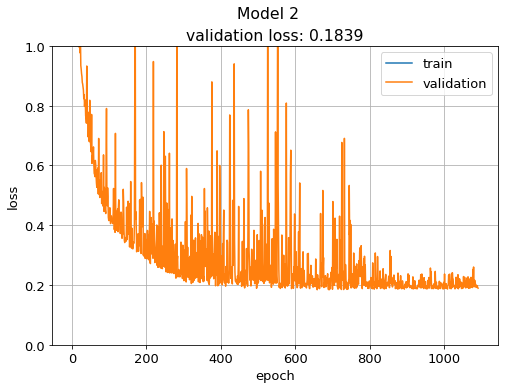

In [103]:
plot_history(history, "Model 2", ymax=1.)

29/29 [==============================] - 0s 893us/step


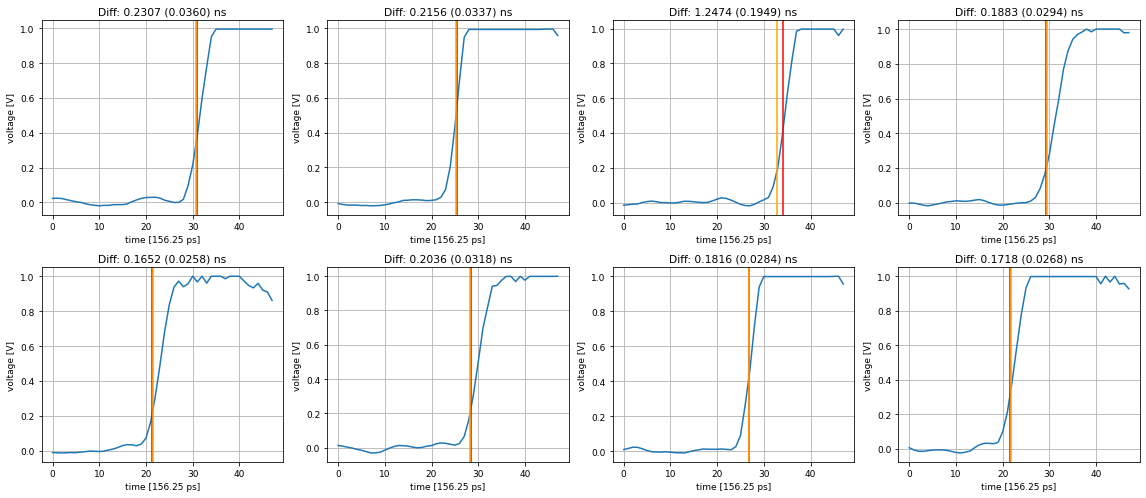

In [104]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

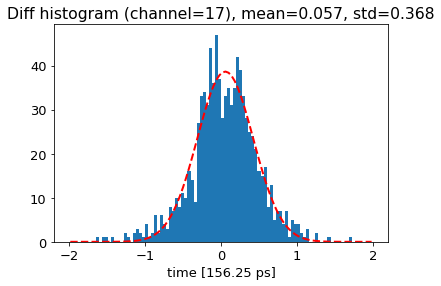

In [105]:
std_2 = plot_difference_hist(y_test, y_pred, 17)

# Model 3

In [ ]:
model = keras.Sequential([
    layers.Input(48),
    layers.Dropout(0.2),
    
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(1)
])

history = train_model(model, lr=0.01, name='model_3', train=True, n_epochs=10000, lr_patience=50, es_patience=1000)

In [ ]:
plot_history(history, "Model 3", ymax=0.4)

In [ ]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

In [ ]:
std_3 = plot_difference_hist(y_test, y_pred, 17)

# Model 4

In [ ]:
model = keras.Sequential([
    layers.Input(48),
    layers.Reshape((-1, 1)),
    
    layers.Conv1D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling1D(2),
    
    layers.Flatten(),
    layers.Dense(1)
])

history = train_model(model, lr=0.1, name='model_4', train=True, n_epochs=3000, lr_patience=50, es_patience=200)

In [ ]:
plot_history(history, "Model 4", ymax=0.4)

In [ ]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

In [ ]:
std_4 = plot_difference_hist(y_test, y_pred, 17)

# Model 5

In [ ]:
model = keras.Sequential([
    layers.Input(48),
    layers.Reshape((-1, 1)),
    
    layers.Conv1D(32, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(32, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(64, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(64, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling1D(2),
    
    layers.Conv1D(128, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(128, 3, padding='same'),
    # layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling1D(2),
    
    layers.Flatten(),
    layers.Dense(1)
])

history = train_model(model, lr=0.001, name='model_5', train=True, n_epochs=3000, lr_patience=100, es_patience=500)
# model.summary()

In [ ]:
plot_history(history, "Model 5", ymax=0.4)

In [ ]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

In [ ]:
std_5 = plot_difference_hist(y_test, y_pred, 17)

# Model 6 (ResNet)

In [ ]:
def residual_block(x, n_filters, strides=2):
    skip = layers.Conv1D(n_filters, 1, strides=strides)(x)
    
    x = layers.Conv1D(n_filters // 4, 1, strides=strides)(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv1D(n_filters // 4, 3, padding='same')(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv1D(n_filters, 1)(x)
    
    x = layers.Add()([skip, x])
    x = layers.ReLU()(x)
    
    return x

inputs = layers.Input(48)
x = layers.Reshape((-1, 1))(inputs)

x = residual_block(x, 32)
x = residual_block(x, 64)
x = residual_block(x, 128)
x = residual_block(x, 256)

# x = layers.Flatten()(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)

#############################################

history = train_model(model, lr=0.001, name='model_6', train=True, n_epochs=5000, lr_patience=100, es_patience=400)
# model.summary()

In [ ]:
plot_history(history, "Model 6", ymax=0.4)

In [ ]:
plt.figure(figsize=(16, 7))
y_pred = model.predict(X_test)[:, 0]
plot_samples(X_test, y_test, y_pred)

In [ ]:
std_6 = plot_difference_hist(y_test, y_pred, 17)

# Model 7 (UNet)

In [ ]:
def gaussian_kernel(mu, sigma=0.8, n=48):
    x = np.arange(0, n)
    return np.exp(-(x - mu)**2 / (2 * sigma**2))

_get_gauss_stats(gaussian_kernel(np.array(1.6)))

In [ ]:
Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

In [ ]:
def conv_block(x, n_filters):
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    skip = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    # skip = residual_block(x, n_filters, strides=1)
    x = layers.MaxPooling1D()(skip)
    return skip, x
    
def deconv_block(x, skip, n_filters):
    x = layers.UpSampling1D()(x)
    x = layers.Conv1D(n_filters, 1, activation='linear')(x)
    x = layers.Concatenate()([skip, x])
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    x = layers.Conv1D(n_filters, 3, activation='relu', padding='same')(x)
    # x = residual_block(x, n_filters, strides=1)
    return x
    
    
###################################

inputs = layers.Input(48)
x = layers.Reshape((-1, 1))(inputs)

skip1, x = conv_block(x, 8)
skip2, x = conv_block(x, 16)
skip3, x = conv_block(x, 32)
x, _ = conv_block(x, 64)

x = deconv_block(x, skip3, 32)
x = deconv_block(x, skip2, 16)
x = deconv_block(x, skip1, 8)

x = layers.Conv1D(1, 1, activation='linear')(x)

outputs = layers.Flatten()(x)

model = tf.keras.Model(inputs, outputs)

#############################################

history = train_model(model, y_train=Y_heatmap_train, y_test=Y_heatmap_test, lr=0.001, name='model_7', train=True, n_epochs=2000, lr_patience=50, es_patience=200, loss_weights=100)
# model.summary()

In [ ]:
plot_history(history, "Model 7", ymax=1)

In [ ]:
plt.figure(figsize=(16, 7))
Y_heatmap_pred = model.predict(X_test)

y_pred = np.empty(Y_heatmap_pred.shape[0])
for i, y in enumerate(Y_heatmap_pred):
    y_pred[i] = _get_gauss_stats(y)
    
plot_samples(X_test, y_test, y_pred, Y_heatmap=Y_heatmap_pred)
mean_squared_error(y_test, y_pred)

In [ ]:
std_7 = plot_difference_hist(y_test, y_pred, 17)

In [ ]:
plot_difference_hist(y_test * TIME_STEP, y_pred * TIME_STEP, 17, hist_range=(-0.35, 0.35), xlabel='time [ns]')

# Compare standard deviations

In [ ]:
print(f"{'CFD':>10}: {std_cfd:0.4f} samples; {std_cfd * TIME_STEP:0.4f} ns")
for i, std in enumerate([std_1, std_2, std_3, std_4, std_5, std_6, std_7]):
    print(f"{f'model_{i+1}':>10}: {std:0.4f} samples; {std * TIME_STEP:0.4f} ns")